In [1]:
import io, requests
from PIL import Image

In [55]:
import json

with open("cats.json", "rb") as data_source:
    cats_data = json.load(data_source)

In [6]:
def fetch_image(url: str, timeout: int = 15) -> Image.Image:
    """
    Fetch an image from a URL and return it as a PIL Image object.
    
    Args:
        url (str): The URL of the image to fetch.
        timeout (int): The timeout for the request in seconds.
        
    Returns:
        Image.Image: The fetched image as a PIL Image object.
    """
    response = requests.get(url, timeout=timeout)
    response.raise_for_status()
    img = Image.open(io.BytesIO(response.content))
    return img.convert("RGB")

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("clip-ViT-B-32")

In [12]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance

dim = 512
client = QdrantClient(url="http://localhost:6333")

if not client.collection_exists("cats"):
    client.create_collection(
        collection_name="cats",
        vectors_config=VectorParams(size=dim, distance=Distance.COSINE),
    )

In [34]:
def save_vector_to_qdrant(vector, collection_name="cats", point_id=None, payload=None):
    """
    Save a vector to a Qdrant collection.
    
    Args:
        vector (np.ndarray): The vector to save.
        collection_name (str): The name of the Qdrant collection.
        point_id (str): Optional ID for the point. If None, Qdrant will generate one.
    """
    
    client.upsert(
        collection_name=collection_name,
        points=[{
            "id": point_id,
            "vector": vector.tolist(),
            "payload": payload
        }],
    )

In [25]:
def find_similar_images(query_vector, collection_name="cats", limit=5):
    """
    Find similar images in a Qdrant collection based on a query vector.

    Args:
        query_vector (np.ndarray): The vector to search for similar images.
        collection_name (str): The name of the Qdrant collection.
        limit (int): The maximum number of similar images to return.

    Returns:
        list: A list of IDs of similar images.
    """
    results = client.query_points(
        collection_name=collection_name,
        query=query_vector.tolist(),  # the vector
        limit=limit
    )
    return results.points

In [ ]:
def load_and_save_images(animals, collection_name="cats"):
    """
    Load images from URLs and save their vectors to Qdrant.

    Args:
        animals (list): List of animals.
        collection_name (str): The name of the Qdrant collection.
    """
    for data in animals:
        try:
            img = data["primary_photo_cropped"]
            if not img or not img["full"]:
                continue
            img_url = img["full"]
            img = fetch_image(img_url)
            vector = model.encode(img)
            payload = {
                "url": data["url"]
            }
            save_vector_to_qdrant(vector, collection_name, point_id=data["id"], payload=payload)
        except Exception as e:
            print(f"Error processing {data["id"]}: {e}")

In [ ]:
load_and_save_images(cats_data, collection_name="cats")

Error processing 77687426: HTTPSConnectionPool(host='dl5zpyw5k3jeb.cloudfront.net', port=443): Read timed out. (read timeout=15)
Error processing 77687429: HTTPSConnectionPool(host='dl5zpyw5k3jeb.cloudfront.net', port=443): Read timed out. (read timeout=15)
Error processing 77592283: HTTPSConnectionPool(host='dl5zpyw5k3jeb.cloudfront.net', port=443): Read timed out. (read timeout=15)
Error processing 77550117: HTTPSConnectionPool(host='dl5zpyw5k3jeb.cloudfront.net', port=443): Read timed out. (read timeout=15)
Error processing 76793044: HTTPSConnectionPool(host='dl5zpyw5k3jeb.cloudfront.net', port=443): Read timed out. (read timeout=15)
Error processing 72993663: 415 Client Error: Unsupported Media Type for url: https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/72993663/1/?bust=1754821152


In [37]:
query_image_url = "https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/77829539/1/?bust=1755409692&width=300"
query_image = fetch_image(query_image_url)
query_vector = model.encode(query_image)

In [38]:
find_similar_images(query_vector, collection_name="cats", limit=5)

[ScoredPoint(id=77829539, version=10, score=0.95080113, payload={'url': 'https://www.petfinder.com/cat/bianca-77829539/ca/oakland/cat-town-ca1848/?referrer_id=bdb3e282-b9fb-4460-9be2-ab2573475b0b&utm_source=api&utm_medium=partnership&utm_content=bdb3e282-b9fb-4460-9be2-ab2573475b0b'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=77438961, version=2004, score=0.93453157, payload={'url': 'https://www.petfinder.com/cat/buffy-77438961/ca/el-dorado-hills/fat-kitty-city-ca1171/?referrer_id=bdb3e282-b9fb-4460-9be2-ab2573475b0b&utm_source=api&utm_medium=partnership&utm_content=bdb3e282-b9fb-4460-9be2-ab2573475b0b'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=75840797, version=3909, score=0.9291264, payload={'url': 'https://www.petfinder.com/cat/mr-woodward-75840797/ca/manteca/orphan-kitten-rescue-info-ca2897/?referrer_id=bdb3e282-b9fb-4460-9be2-ab2573475b0b&utm_source=api&utm_medium=partnership&utm_content=bdb3e282-b9fb-4460-9be2-ab2573475b0b'}, vector=N

In [ ]:
validation_data = []

"""
Each animal could have multiple photos
We use the second photo as validation data
"""
for animal in cats_data:
    try:
        photos = animal["photos"]
        if not photos or len(photos) == 1: 
            continue
        validation_data.append({
            "id": animal["id"],
            "url": photos[1]["full"],
        })
    except Exception as e:
        print(f"Error processing {animal['id']}: {e}")

In [53]:
def average_position_at_k(retrieved, relevant, k=5):
    """
    Calculate the average position of relevant items in the retrieved list.

    Args:
        retrieved (list): List of retrieved item IDs.
        relevant (list): List of relevant item IDs.
        k (int): The number of top items to consider.

    Returns:
        float: The average position of relevant items, or None if no relevant items are found.
    """
    scores = 0
    relevant_found = 0
    for i, item in enumerate(retrieved[:k]):
        if item in relevant:
            relevant_found += 1
        scores += relevant_found / (i + 1)
    return scores / len(relevant)

def mean_average_precision(validation_data, k=5):
    """
    Calculate the Mean Average Precision (MAP) for a list of retrieved items.

    Args:
        retrieved (list): List of retrieved item IDs.
        relevant (list): List of relevant item IDs.
        k (int): The number of top items to consider.

    Returns:
        float: The MAP score.
    """
    ap_sum = 0
    for data in validation_data:
        retrieved_points = find_similar_images(model.encode(fetch_image(data["url"])), collection_name="cats", limit=k)
        retrieved_ids = [point.id for point in retrieved_points]
        relevant_id = [data["id"]]
        # print(f"Retrieved IDs: {retrieved_ids}, Relevant ID: {relevant_id}")
        ap = average_position_at_k(retrieved_ids, relevant_id, k)
        if ap is not None:
            ap_sum += ap
    return ap_sum / len(validation_data)

In [54]:
mean_average_precision(validation_data[:1000])

0.6215166666666686

In [71]:
import matplotlib.pyplot as plt

def compare_query_with_hits(query_image, hits):
    """
    Compare a query image with retrieved hits and display the results.

    Args:
        query_image (Image.Image): The query image.
        hits (list): List of retrieved hits.
    """
    n = len(hits) + 1
    _, axes = plt.subplots(1, n, figsize=(3*n, 3))
    axes[0].imshow(query_image)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for h in hits:
        cat_id = h.id
        match = next((cat for cat in cats_data if cat["id"] == cat_id), None)
        if match is None:
            continue
        img_url = match["primary_photo_cropped"]["full"]
        img = fetch_image(img_url)
        axes[hits.index(h) + 1].imshow(img)
        axes[hits.index(h) + 1].set_title(f"Hit {cat_id}")
        axes[hits.index(h) + 1].axis("off")
    plt.show()

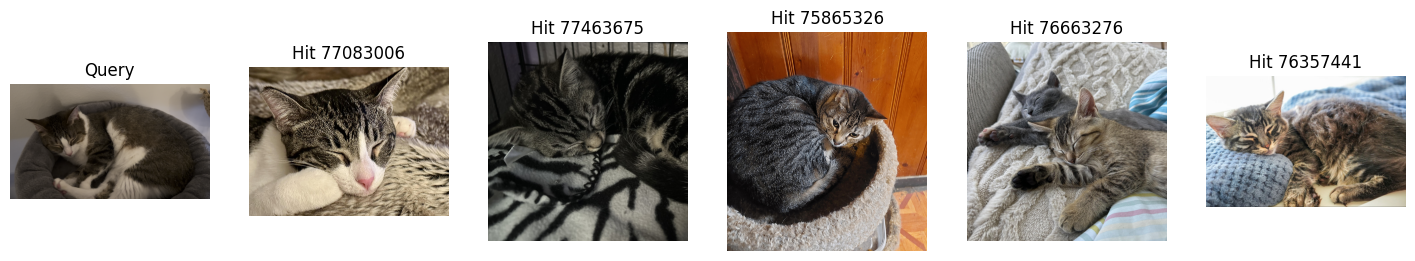

In [72]:
# samples
sample_image = Image.open("gomez.png").convert("RGB")
sample_query = model.encode(sample_image)
sample_retrieved = find_similar_images(sample_query, collection_name="cats", limit=5)
compare_query_with_hits(sample_image, sample_retrieved)